In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

# Import the PyTorch library.
import torch

# Import the PyTorch neural network library.
import torch.nn as nn

# Import the PyTorch optimization library.
import torch.optim as optim

# Import the PyTorch learning rate scheduler library.
from torch.optim import lr_scheduler

# Import the PyTorch CuDNN library.
import torch.backends.cudnn as cudnn

# Import the NumPy library.
import numpy as np

# Import the TorchVision library.
import torchvision

# Import the TorchVision datasets library.
from torchvision import datasets

# Import the TorchVision models library.
from torchvision import models

# Import the TorchVision transforms library.
from torchvision import transforms

# Import the Matplotlib library.
import matplotlib.pyplot as plt

# Import the time library.
import time

# Import the operating system library.
import os

# Import the copy library.
import copy

# tells PyTorch to benchmark different convolution algorithms and 
# choose the fastest one for your specific hardware configuration
cudnn.benchmark = True
plt.ion()   # interactive mode

### Normalization is a common preprocessing step for machine learning models that are trained on image data. It helps to improve the performance of the models by making the data more consistent.

### The transforms.Normalize function takes two arguments: the mean and the standard deviation. The mean is the average value of each channel in the image, and the standard deviation is the standard deviation of each channel in the image.

### The transforms.Normalize function works by subtracting the mean from each channel in the image and then dividing by the standard deviation. This effectively centers the data around 0 and scales it to a range of [-1, 1].

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [4]:
data_dir = 'data/hymenoptera_data'

# creates a dictionary called image_datasets. The dictionary maps the strings train and val to ImageFolder objects. 
# The ImageFolder objects are used to load the training and validation datasets.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# creates a dictionary called dataloaders. The dictionary maps the strings train and val to DataLoader objects. 
# The DataLoader objects are used to load the training and validation datasets in batches.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# creates a dictionary called dataset_sizes. The dictionary maps the strings train and val to the number of 
# images in the training and validation datasets.
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# fetch the class names
class_names = image_datasets['train'].classes

In [5]:
# Check if the GPU is available
if torch.cuda.is_available():
    # Use the GPU
    device = torch.device("cuda:0")
# elif torch.backends.mps.is_available():
#     # Use the MPS
#     device = torch.device("mps")
else:
    # Use the CPU
    device = torch.device("cpu")

In [6]:
device.type

'cpu'

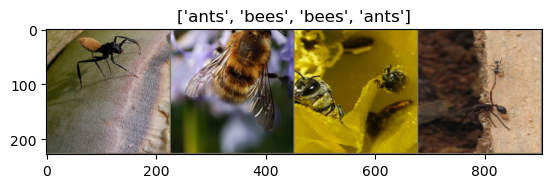

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # # M1 macbook does not support float64 so need to convert to float32
                # if device.type == 'mps':
                #     # Convert inputs and labels to float32
                #     inputs = inputs.to(torch.float32)
                #     labels = labels.to(torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # context manager is used to disable gradient calculation in PyTorch. 
    # This can be useful for inference, when you are sure that you will not call Tensor.backward(). 
    # Disabling gradient calculation can reduce memory consumption for computations that would otherwise have requires_grad=True.
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
# reference model
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5508 Acc: 0.7131
val Loss: 0.4013 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.6029 Acc: 0.7459
val Loss: 0.1992 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5339 Acc: 0.7828
val Loss: 0.4864 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4543 Acc: 0.8320
val Loss: 0.3967 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.4568 Acc: 0.8320
val Loss: 0.2305 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4152 Acc: 0.8279
val Loss: 0.2649 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6849 Acc: 0.7500
val Loss: 0.4413 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.5326 Acc: 0.8197
val Loss: 0.1744 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3244 Acc: 0.8689
val Loss: 0.1889 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3357 Acc: 0.8525
val Loss: 0.1716 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2716 Acc: 0.8934
val Loss: 0.1745 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2827 Acc: 0.8852
val Loss: 0.1660 Acc: 0.9477

Ep

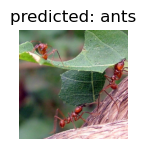

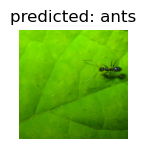

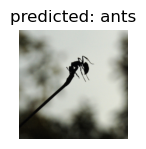

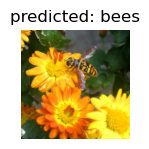

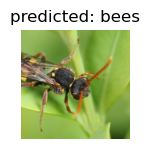

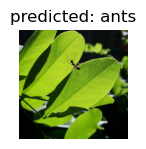

In [13]:
visualize_model(model_ft)

In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5399 Acc: 0.7172
val Loss: 0.5329 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.4744 Acc: 0.7787
val Loss: 0.4422 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.5327 Acc: 0.7500
val Loss: 0.1750 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.4172 Acc: 0.8156
val Loss: 0.1998 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4565 Acc: 0.8156
val Loss: 0.3080 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.5270 Acc: 0.7828
val Loss: 0.2528 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5083 Acc: 0.7828
val Loss: 0.2351 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3620 Acc: 0.8648
val Loss: 0.1704 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4043 Acc: 0.8238
val Loss: 0.1761 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3336 Acc: 0.8484
val Loss: 0.1611 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3874 Acc: 0.8197
val Loss: 0.1664 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4240 Acc: 0.8074
val Loss: 0.1631 Acc: 0.9608

Ep

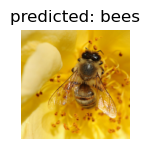

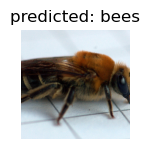

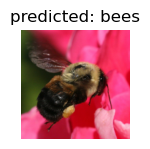

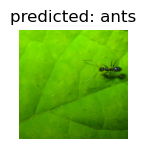

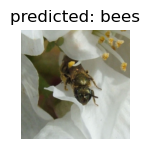

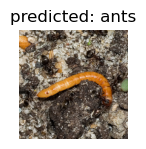

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()